In [3]:
# Aloe Token
token="74b1aaf8ca3f131071be811964fd2987"
ktoken="eb3accfaee2cf54ebed2e6d3caac72"

# Abaco Tools

In [ ]:
import os
import time 
import numpy as np
import pandas as pd
import pprint as pp
import requests as r

header_dat={'Authorization': f'Bearer {token}'}
url = "https://dev.tenants.aloedev.tacc.cloud/actors/v2"

In [ ]:
# Get all actors.
actor = r.get(f"{url}",
               headers=header_dat)
actor.json()

In [33]:
# Create actor for work
actor = r.post(f"{url}",
               headers=header_dat,
               data={'image':'notchristiangarcia/flops_test:6.0'})
actor_id = actor.json()['result']['id']
actor.json();

In [31]:
# Delete specified actors.
for del_actor in [actor_id ,'qOxAKjG7zVqkE']:
    del_actor_res = r.delete(f"{url}/{del_actor}",
                     headers=header_dat)
    print(del_actor_res.json())

{'message': 'Actor deleted successfully.', 'result': None, 'status': 'success', 'version': ':dev2'}
{'message': 'Actor deleted successfully.', 'result': None, 'status': 'success', 'version': ':dev2'}


In [35]:
# Check number of workers currently available
worker_res = r.get(f"{url}/{actor_id}/workers",
                    headers=header_dat)
num_workers = len(worker_res.json()['result'])
print(num_workers)

host_info = {}
all_workers = []
try:
    if num_workers:
        for worker_info in worker_res.json()['result']:
            if f"Host {worker_info['hostId']}" in host_info:
                host_info[f"Host {worker_info['hostId']}"] += 1
            else:
                host_info[f"Host {worker_info['hostId']}"] = 1
        for worker_info in worker_res.json()['result']:
            all_workers.append(worker_info['id'])
except KeyError:
    print('Still spooling.')
worker_res.json();
#host_info

0


{}

In [36]:
# Spool up more workers
try:
    start_workers = time.time()
    workers_needed = 582
    curr_workers = 0
    incr = 50
    while workers_needed != curr_workers:
        if curr_workers + incr > workers_needed:
            curr_workers += (workers_needed - curr_workers) % incr
        else:
            curr_workers += incr

        print(f'Getting {curr_workers} workers')
        spool_res = r.post(f"{url}/{actor_id}/workers",
                            headers=header_dat,
                            data={'num': curr_workers})
except:
    print(time.time() - start_workers)

Getting 50 workers
Getting 100 workers
Getting 150 workers
Getting 200 workers
Getting 250 workers
Getting 300 workers
Getting 350 workers
Getting 400 workers
Getting 450 workers
Getting 500 workers
Getting 550 workers
Getting 582 workers


In [27]:
# Delete all current workers!
worker_res = r.get(f"{url}/{actor_id}/workers",
                        headers=header_dat)
print('Deleted Workers:')
for worker_info in worker_res.json()['result']:
    del_worker_res = r.delete(f"{url}/{actor_id}/workers/{worker_info['id']}",
                        headers=header_dat)
    print('.', end='')

Deleted Workers:
.

# This breaks things

In [93]:
import time
import multiprocessing
import requests as r

msg_dat = f'0 1000 20' # Threads/Std_dev/Size
messager_inp = [actor_id, header_dat, msg_dat]
messager_iterator = [messager_inp] * 2670 # Executions

def send_actor_message(it):
    while True:
        start_msg = time.time()
        try:
            msg_send = r.post(f"https://dev.tenants.aloedev.tacc.cloud/actors/v2/{it[0]}/messages",
                              headers=it[1], data={'message': it[2]})
            return [msg_send.json()['result']['executionId'], time.time() - start_msg]
        except:
            print(time.time()-start_msg)
            print(msg_send.content)
            return [msg_send.content, time.time() - start_msg]

pool = multiprocessing.Pool(processes=8)
msg_start = time.time()
exec_id_list = pool.map(send_actor_message, messager_iterator)
pool.close()
pool.join()
msg_end = time.time()
print(f'Messaging complete - {msg_end-msg_start}')

outputs = list(map(list, zip(*exec_id_list)))[1]

Messaging complete - 509.9068241119385


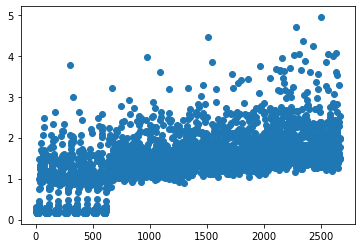

In [94]:
import matplotlib.pyplot as plt
plt.scatter(range(len(outputs)), outputs)

# Everything that you really just don't need to see at all.

In [32]:
nodes = 2 #os.environ['nodes']

# Get all current workers
worker_res = r.get(f"{url}/{actor_id}/workers",
                        headers=header_dat)
all_workers = []
for worker_info in worker_res.json()['result']:
    all_workers.append(worker_info['id'])
    
# Delete all current workers
for del_worker in all_workers:
    del_worker_res = r.delete(f"{url}/{actor_id}/workers/{del_worker}",
                        headers=header_dat)

# Spool up more workers!
worker_res = r.post(f"{url}/{actor_id}/workers",
                    headers=header_dat,
                    data={'num': nodes*6})

# Check on amount of workers
while True:
    worker_res = r.get(f"{url}/{actor_id}/workers",
                        headers=header_dat)
    num_workers = len(worker_res.json()['result'])
    if not num_workers == nodes*6:
        continue
    
    host_info = {}
    if num_workers:
        try:
            for worker_info in worker_res.json()['result']:
                worker_info['hostId']
            break
        except KeyError:
            continue

In [ ]:
all_data = pd.DataFrame()

actor_id = 'peorL6Eg4GPW3'

nodes = 1
workers_per_node = 6
messages_per_worker = 10

threads = 0        # set to 0 for all threads
std_dev = 1000
size = 1000
executions = nodes * workers_per_node * messages_per_worker
messageDat = f'{threads} {std_dev} {size}'
runs = 3

for run_num in range(1, runs + 1):
    print(f'Starting Run {run_num}.')
    msg_start = time.time()
    exec_id_list = []
    for i in range(executions):
        execution = r.post(f"{url}/{actor_id}/messages",
                           headers=header_dat,
                           data={'message':messageDat})
        exec_id = execution.json()['result']['executionId']
        exec_id_list.append(exec_id)
        print(f'\rCreated execution: {i+1}', end='')
    msg_end = time.time()

    exec_start = time.time()
    results_list = []
    
    executions_completed = 0
    while exec_id_list:
        for exec_id in exec_id_list:
            exec_logs = r.get(f"{url}/{actor_id}/executions/{exec_id}/logs",
                              headers=header_dat)

            logs = exec_logs.json()['result']['logs']
            if logs:
                print(f'\rExecutions completed: {executions_completed + 1}', end='')
                results_list.append([f'id - {exec_id}', float(logs.replace('\n',''))])
                exec_id_list.remove(exec_id)
                executions_completed += 1
    exec_end = time.time()

    work_time = 0
    for res in results_list:
        work_time += res[1]

    print(f"\n\nRun Number {run_num}")
    if threads:
        print(f"Threads: {threads}")
    print(f"Std Dev: {std_dev}")
    print(f"Size: {size}")
    print(f"Executions: {executions}")
    print(f"Message Time: {msg_end - msg_start}")
    print(f"Exec Time: {exec_end - exec_start}")
    print(f"Work Time: {work_time}")
    print('\n')

    run_data = pd.DataFrame([[run_num, threads, std_dev, size, executions, msg_end - msg_start, exec_end - exec_start, work_time]],
                            columns=['Run Number', 'Threads', 'Std Dev', 'Size', 'Executions', 'Message Time', 'Exec Time', 'Work Time'])
    all_data = all_data.append(run_data, ignore_index = True)
all_data.to_csv(f'{nodes}_nodes_{runs}_trials.csv')

# Hyper Parameter Testing

In [ ]:
# Hyper paramater tester
actor_id = 'peorL6Eg4GPW3'

all_data = pd.DataFrame()
for test_var in [1000, 2000, 3000]:
    nodes = 1
    workers_per_node = 6
    messages_per_worker = 5

    threads = 0        # set to 0 for all threads
    std_dev = 1000
    size = test_var
    executions = nodes * workers_per_node * messages_per_worker
    messageDat = f'{threads} {std_dev} {size}'
    runs = 3

    for run_num in range(1, runs + 1):
        print(f'Starting Run {run_num}.')
        msg_start = time.time()
        exec_id_list = []
        for i in range(executions):
            execution = r.post(f"{url}/{actor_id}/messages",
                               headers=header_dat,
                               data={'message':messageDat})
            exec_id = execution.json()['result']['executionId']
            exec_id_list.append(exec_id)
            print(f'\rCreated execution: {i+1}', end='')
        msg_end = time.time()

        exec_start = time.time()
        results_list = []

        executions_completed = 0
        while exec_id_list:
            for exec_id in exec_id_list:
                exec_logs = r.get(f"{url}/{actor_id}/executions/{exec_id}/logs",
                                  headers=header_dat)

                logs = exec_logs.json()['result']['logs']
                if logs:
                    print(f'\rExecutions completed: {executions_completed + 1}', end='')
                    results_list.append([f'id - {exec_id}', float(logs.replace('\n',''))])
                    exec_id_list.remove(exec_id)
                    executions_completed += 1
        exec_end = time.time()

        work_time = 0
        for res in results_list:
            work_time += res[1]

        print(f"\n\nRun Number {run_num}")
        if threads:
            print(f"Threads: {threads}")
        print(f"Std Dev: {std_dev}")
        print(f"Size: {size}")
        print(f"Executions: {executions}")
        print(f"Message Time: {msg_end - msg_start}")
        print(f"Exec Time: {exec_end - exec_start}")
        print(f"Work Time: {work_time}")
        print('\n')

    run_data = pd.DataFrame([[run_num, threads, std_dev, size, executions, msg_end - msg_start, exec_end - exec_start, work_time]],
                            columns=['Run Number', 'Threads', 'Std Dev', 'Size', 'Executions', 'Message Time', 'Exec Time', 'Work Time'])
    all_data = all_data.append(run_data, ignore_index = True)
all_data.to_csv(f'{nodes}_nodes_{runs}_trials.csv')


# LEGACY

In [ ]:
# message = "'std_deviation' 'size'"
messageDat = '3 10 1000'
executions = 8

# Actor that will be creating workers with flop test.
actor = r.post(f"{url}/actors",
               headers=header_dat,
               data={'image':'notchristiangarcia/flops_test'})
actor_id = actor.json()['result']['id']


# Executions of this actor, lots of times.
exec_id_list = []
for i in range(executions):
    execution = r.post(f"{url}/actors/{actor_id}/messages",
                       headers=header_dat,
                       data={'message':messageDat})
    exec_id = execution.json()['result']['executionId']
    exec_id_list.append(exec_id)


# Getting result of exec from log once exec complete.
results_dict = {}
while exec_id_list:
    for exec_id in exec_id_list:
        exec_logs = r.get(f"{url}/actors/{actor_id}/executions/{exec_id}/logs",
                          headers=header_dat)

        logs = exec_logs.json()['result']['logs']
        if logs:
            results_dict[f'id - {exec_id}'] = float(logs.replace('\n',''))
            exec_id_list.remove(exec_id)

In [ ]:
# message = "'threads' 'std_deviation' 'size'"
messageDat = '1 10 1500'
executions = 8

msg_start = time.time()
exec_id_list = []
for i in range(executions):
    execution = r.post(f"{url}/actors/{actor_id}/messages",
                       headers=header_dat,
                       data={'message':messageDat})
    exec_id = execution.json()['result']['executionId']
    exec_id_list.append(exec_id)
msg_end = time.time()

In [ ]:
exec_start = time.time()
results_list = []
while exec_id_list:
    for exec_id in exec_id_list:
        exec_logs = r.get(f"{url}/actors/{actor_id}/executions/{exec_id}/logs",
                          headers=header_dat)

        logs = exec_logs.json()['result']['logs']
        if logs:
            print('. ', end='')
            results_list.append([f'id - {exec_id}', float(logs.replace('\n',''))])
            exec_id_list.remove(exec_id)
exec_end = time.time()

work_time = 0
for res in results_list:
    work_time += res[1]

print(f"\n\nExec Time: {exec_end - exec_start}")
print(f"Message Time: {msg_end - msg_start}")
print(f"Work Time: {work_time}")
pp.pprint(results_list)